**Problem**: 

I want to approximate the non-linear data space that makes up a PyPSA simulation. Specifically, I want to approximate a modified IEEE 13 bus topology with a uniform (grid) input. The approximation should be time sensitive.

**Objective**:

This notebook will only look at [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (SVR) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will be shown for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, linear regression models outperformed artificial neural networks when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

The model was unable to predict the first label. This is expected because the node represented by the label is a slack bus and therefore its voltage is always 1. The results for the other labels were averaged

* 1e4 samples (mean R2: 0.88, std dev: 0.002)
* 1e3 samples (mean R2: 0.87, std dev: 0.014)
* 1e2 samples (mean R2: 0.79, std dev: 0.076)
* 1e1 samples (mean R2: -15, std dev: 19)

If the slack bus is removed the results improve by roughly 9%

* 1e4 samples (mean R2: 0.96, std dev: 0.002)
* 1e3 samples (mean R2: 0.95, std dev: 0.009)
* 1e2 samples (mean R2: 0.87, std dev: 0.069)
* 1e1 samples (mean R2: -16, std dev: 20)

From 1e3 to 1e4 samples there is not a significant improvement in mean R2 (1%), but there is in the std dev (). From 1e2 to 1e3 it is more apparent (9%). Running a grid search with 1e3 samples produced the following results:

1. Mean R2: ? std dev: ?
2. Mean R2: ? std dev: ?
3. .
4. .

Tried training the model on 1e5 samples for over 5 hours. Cancelled.

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup grid search

In [29]:
import pypsa
import time
import logging
import numpy as np
import warnings

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

import copy
import csv
import sys
import time

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing

In [30]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")
    
import pandas as pd
import numpy as np
    
def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''
    Modifies common .csv files in PyPSA folders with uniformly sampled data 

    Parameters
    ----------
    path_to_powerflow_data: string
        ex: "/home/user/Documents/powerflow_data/"
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    n_samples: int
    
    seed=None: int
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))

def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    import shutil
    from pathlib import Path
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/" # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_uniform_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")
    
def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import os
    import errno
    import shutil
    
    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)
            
def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe

# Source Data

In [31]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example +
                          "/ieee-13-with-load-gen-uniform-data-"
                          + str(sample_size) +
                          "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [32]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [33]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc104930190>,
      dtype=object)

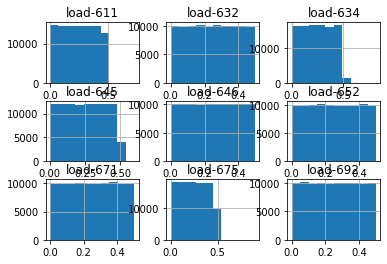

In [34]:
features.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc108054fd0>,
      dtype=object)

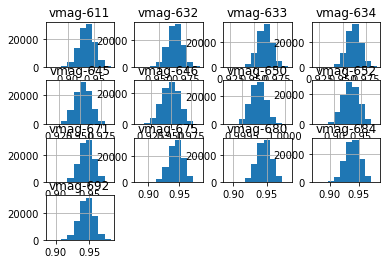

In [35]:
labels.hist()

In [36]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.008439,0.001458,-0.002953,-0.000081,-0.001955,-0.007134,-0.001353,-0.004306,-0.001971,-0.002970
vmag-646,-0.196512,-0.200144,-0.487273,-0.671172,-0.211606,-0.204674,-0.199273,-0.208235,-0.211118,-0.287779
vmag-645,-0.219407,-0.223990,-0.546822,-0.558979,-0.235927,-0.229190,-0.223332,-0.233060,-0.236599,-0.300812
vmag-632,-0.316812,-0.320804,-0.319882,-0.333944,-0.339195,-0.329811,-0.324215,-0.334387,-0.339914,-0.328774
vmag-633,-0.286406,-0.512513,-0.289868,-0.302645,-0.307178,-0.298881,-0.292050,-0.303695,-0.307554,-0.322310
vmag-634,-0.286326,-0.512387,-0.289801,-0.302548,-0.307111,-0.298800,-0.291940,-0.303616,-0.307463,-0.322221
vmag-611,-0.157880,-0.158084,-0.155850,-0.168281,-0.463138,-0.316864,-0.313902,-0.320260,-0.600170,-0.294936
vmag-684,-0.170285,-0.171447,-0.168631,-0.182151,-0.502244,-0.343257,-0.340429,-0.346904,-0.501052,-0.302933
vmag-671,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.410221,-0.313491
vmag-692,-0.196689,-0.199299,-0.196616,-0.210148,-0.410075,-0.399049,-0.395916,-0.403413,-0.410151,-0.313484


# Setup Models

In [37]:
import csv
import datetime

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scoring import rmse

In [38]:
def set_data_size(n_samples, n_training_samples):
    X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val

# Determine number of samples to get reasonable scores

In [39]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
svr = SVR(gamma='scale', C=1.0, epsilon=0.0002, kernel='rbf')

linear = LinearRegression()

In [ ]:
svr_xval_scores = []
linear_xval_scores = []
for i, n_samples in enumerate([100, 1000, 10000, 100000]):
    current_iteration = i

    n_training_samples = int(n_samples*(80/100))
    X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

    print("\n\nRun: ", current_iteration)
    print("n_training_samples: ", n_training_samples)
    print("n_validation_samples: ", n_samples-n_training_samples)
    print("n_features: ", X_train.shape[1])
    print("n_labels: ", y_train.shape[1])

    ## svr - can only predict one label at a time
    print("\n\nSVR\n\n")
    
    time_start = time.time()
    svr_models = []
    for label in range(y_train.shape[1]):
        svr_y_train = y_train.T[label].T
        svr_xval_scores = pd.DataFrame(cross_validate(svr, 
                                                      X_train, 
                                                      svr_y_train, 
                                                      cv=5, 
                                                      n_jobs=-1, 
                                                      scoring={"r2": make_scorer(r2_score),
                                                               "rmse": make_scorer(rmse),
                                                               "mae": make_scorer(mae)}))
        svr_xval_scores.columns = ["svr_" + col + "_label_" + str(label) for col in svr_xval_scores.columns]
        if label == 0:
            svr_results = svr_xval_scores
        else:
            svr_results = svr_results.join(svr_xval_scores)
        
        svr_models.append(svr.fit(X_train, svr_y_train))

    time_svr = time.time()
    print("cross validation training time {:.5}".format(time_svr-time_start))
    print("cross validation training scores: ")
    svr_results = add_mean_and_std_rows(svr_results)
    display(svr_results)

    print("non-cross validation model scores for reference:")
    for label in range(y_train.shape[1]):
        print("label: ", label)
        print("training score: ", r2_score(y_train.T[label].T, svr.predict(X_train)))
        print("validation score: ", r2_score(y_val.T[label].T, svr.predict(X_val)))
        print("rmse: ", rmse(y_val.T[label].T, svr.predict(X_val)))

    ## linear regression
    print("\n\nLINEAR REGRESSION\n\n")
    time_start = time.time()
    linear_xval_scores.append(cross_validate(linear,
                                             X_train,
                                             y_train,
                                             cv=5,
                                             n_jobs=-1,
                                             scoring={"r2": make_scorer(r2_score),
                                                      "rmse": make_scorer(rmse),
                                                      "mae": make_scorer(mae)}))

    time_linear = time.time()
    print("cross validation training time {:.5}".format(time_linear-time_start))
    print("cross validation training scores: ")
    linear_results = pd.DataFrame(linear_xval_scores[current_iteration])
    linear_results.columns = ["linear_"+col for col in linear_results.columns]
    linear_results = add_mean_and_std_rows(linear_results)
    display(linear_results)

    linear.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, linear.predict(X_train)))
    print("validation score: ", r2_score(y_val, linear.predict(X_val)))
    print("rmse: ", rmse(linear.predict(X_val), y_val))

    ## model statistics
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    results_to_save = linear_results.join(svr_results).round(3)
    results_to_save.to_csv(path_to_powerflow_data + 
                           "/results/approximating_with_svr_results-{}_samples-{}.csv".format(n_samples, 
                                                                                             datetimestamp))



Run:  0
n_training_samples:  80
n_validation_samples:  20
n_features:  9
n_labels:  13


SVR


cross validation training time 1.2083
cross validation training scores: 


,svr_fit_time_label_0,svr_score_time_label_0,svr_test_r2_label_0,svr_test_rmse_label_0,svr_test_mae_label_0,svr_fit_time_label_1,svr_score_time_label_1,svr_test_r2_label_1,svr_test_rmse_label_1,svr_test_mae_label_1,...,svr_fit_time_label_11,svr_score_time_label_11,svr_test_r2_label_11,svr_test_rmse_label_11,svr_test_mae_label_11,svr_fit_time_label_12,svr_score_time_label_12,svr_test_r2_label_12,svr_test_rmse_label_12,svr_test_mae_label_12
0,0.000857,0.001216,-0.070754,0.000093,0.000070,0.000906,0.001138,0.725519,0.004807,0.003456,...,0.000826,0.001148,0.749972,0.004888,0.003785,0.001030,0.001698,0.686592,0.003968,0.003194
1,0.000838,0.001157,-0.026519,0.000084,0.000073,0.000788,0.001062,0.873864,0.003466,0.002804,...,0.003335,0.001309,0.868880,0.004480,0.004124,0.003355,0.001770,0.854295,0.002981,0.002487
2,0.000565,0.001207,-0.254505,0.000100,0.000079,0.000712,0.001111,0.835298,0.004174,0.003398,...,0.000855,0.001151,0.792538,0.007642,0.005740,0.001029,0.001853,0.803615,0.004598,0.003534
3,0.000524,0.001130,-0.003594,0.000088,0.000070,0.000921,0.001093,0.916946,0.003069,0.002359,...,0.000765,0.001123,0.914202,0.005237,0.003627,0.000759,0.001273,0.899234,0.003777,0.002822
4,0.000570,0.001015,-0.661189,0.000068,0.000056,0.000709,0.001056,0.764335,0.005187,0.003728,...,0.000862,0.001236,0.847434,0.007346,0.005306,0.001312,0.001403,0.824470,0.005387,0.003561
mean,0.000671,0.001145,-0.203312,0.000087,0.000070,0.000807,0.001092,0.823192,0.004141,0.003149,...,0.001329,0.001193,0.834605,0.005919,0.004516,0.001497,0.001599,0.813641,0.004142,0.003120
std,0.000162,0.000081,0.274311,0.000012,0.000009,0.000102,0.000034,0.078276,0.000886,0.000556,...,0.001122,0.000078,0.064435,0.001467,0.000949,0.001057,0.000249,0.079590,0.000904,0.000464


non-cross validation model scores for reference:
label:  0
training score:  -405175.1157755053
validation score:  -452955.5851603119
rmse:  0.05441855980311887
label:  1
training score:  0.4138143894934786
validation score:  0.6008956470339313
rmse:  0.007792955396202384
label:  2
training score:  0.08104679208297072
validation score:  0.2997401786933088
rmse:  0.009048557066661852
label:  3
training score:  -8.299408269172135
validation score:  -5.088419892025565
rmse:  0.019293956406146524
label:  4
training score:  -4.561801734886986
validation score:  -2.654685557035367
rmse:  0.016006511525650476
label:  5
training score:  -4.529157846112978
validation score:  -2.636018245980058
rmse:  0.01594999955233893
label:  6
training score:  0.3463968418696538
validation score:  0.5654887130041037
rmse:  0.01098062493251547
label:  7
training score:  0.6522920410024485
validation score:  0.7226476376974607
rmse:  0.008237736397344255
label:  8
training score:  0.998848625655069
validation s

,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae
0,0.010338,0.001400,0.887021,0.001360,0.001038
1,0.008770,0.001488,0.868170,0.001446,0.001193
2,0.000743,0.001277,0.892865,0.001621,0.001189
3,0.001001,0.001257,0.863797,0.001600,0.001176
4,0.000698,0.000962,0.794419,0.001180,0.000831
mean,0.004310,0.001277,0.861254,0.001441,0.001085
std,0.004821,0.000199,0.039321,0.000182,0.000156


non-cross validation model scores for reference:
training score:  0.9126665954697695
validation score:  0.8987932814837764
rmse:  0.0014147555230062368


Run:  1
n_training_samples:  800
n_validation_samples:  200
n_features:  9
n_labels:  13


SVR


cross validation training time 4.9363
cross validation training scores: 


,svr_fit_time_label_0,svr_score_time_label_0,svr_test_r2_label_0,svr_test_rmse_label_0,svr_test_mae_label_0,svr_fit_time_label_1,svr_score_time_label_1,svr_test_r2_label_1,svr_test_rmse_label_1,svr_test_mae_label_1,...,svr_fit_time_label_11,svr_score_time_label_11,svr_test_r2_label_11,svr_test_rmse_label_11,svr_test_mae_label_11,svr_fit_time_label_12,svr_score_time_label_12,svr_test_r2_label_12,svr_test_rmse_label_12,svr_test_mae_label_12
0,0.000823,0.001165,-0.000004,0.000082,0.000065,0.109184,0.016226,0.950383,0.002315,0.001801,...,0.092950,0.013116,0.950961,0.003491,0.002772,0.079348,0.013942,0.945957,0.002459,0.001961
1,0.000806,0.001103,-0.012610,0.000088,0.000073,0.081106,0.012866,0.957941,0.002291,0.001752,...,0.105874,0.013567,0.953417,0.003205,0.002505,0.065849,0.012806,0.945251,0.002411,0.001874
2,0.000674,0.001247,-0.080092,0.000094,0.000076,0.094849,0.012330,0.957001,0.002071,0.001631,...,0.096464,0.013121,0.958581,0.003002,0.002404,0.078427,0.012714,0.954933,0.002164,0.001744
3,0.000548,0.001131,-0.013122,0.000086,0.000070,0.063049,0.012321,0.949957,0.002239,0.001808,...,0.093220,0.013172,0.952578,0.003159,0.002471,0.080854,0.012641,0.946141,0.002382,0.001896
4,0.000546,0.001174,-0.022438,0.000088,0.000069,0.071282,0.011936,0.955996,0.002317,0.001851,...,0.091927,0.012665,0.951379,0.003383,0.002601,0.078922,0.012608,0.949684,0.002388,0.001917
mean,0.000679,0.001164,-0.025653,0.000088,0.000071,0.083894,0.013136,0.954256,0.002246,0.001768,...,0.096087,0.013128,0.953383,0.003248,0.002551,0.076680,0.012942,0.948393,0.002361,0.001879
std,0.000134,0.000054,0.031460,0.000005,0.000004,0.018445,0.001759,0.003795,0.000103,0.000085,...,0.005729,0.000320,0.003064,0.000192,0.000143,0.006123,0.000564,0.004041,0.000114,0.000082


non-cross validation model scores for reference:
label:  0
training score:  -399282.3767483447
validation score:  -382951.4335061642
rmse:  0.05342864243653316
label:  1
training score:  0.3634260911267302
validation score:  0.35969327392528494
rmse:  0.008280264914777428
label:  2
training score:  -0.07581320922451851
validation score:  -0.047684008994790306
rmse:  0.009482818407689332
label:  3
training score:  -8.563168616271307
validation score:  -8.30556376741714
rmse:  0.019176874717821667
label:  4
training score:  -4.729535136097592
validation score:  -4.351725244428486
rmse:  0.01646841109873197
label:  5
training score:  -4.690669532697653
validation score:  -4.3181608359821
rmse:  0.016422356558590003
label:  6
training score:  0.2773072928078003
validation score:  0.25917617568744744
rmse:  0.011292747478352442
label:  7
training score:  0.6141145413935973
validation score:  0.5900027519633404
rmse:  0.007721538029294059
label:  8
training score:  0.998617377751722
validati

,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae
0,0.004205,0.001579,0.902568,0.001372,0.001059
1,0.002871,0.002625,0.903212,0.001434,0.001103
2,0.001262,0.001512,0.901215,0.001466,0.001116
3,0.001126,0.001463,0.902802,0.001356,0.001033
4,0.001224,0.001429,0.905953,0.001442,0.001085
mean,0.002137,0.001721,0.903150,0.001414,0.001079
std,0.001364,0.000508,0.001737,0.000047,0.000033


non-cross validation model scores for reference:
training score:  0.905871026771822
validation score:  0.9043735413742711
rmse:  0.0013589426825525242


Run:  2
n_training_samples:  8000
n_validation_samples:  2000
n_features:  9
n_labels:  13


SVR




# Importing results for calculating mean/std

This is different than the RF/DNN notebooks because there are more numbers to crunch

In [13]:
def mean_and_std(results_dataframe, label_min):
    for score in ["r2", "rmse", "mae"]:
        df = [col for col in results_dataframe.columns if all(["svr" in col, score + "_score" in col])]
        print("{} mean: {:.5} std: {:.5} for labels from {} to 12".format(score,
                                                                          df.mean().mean(), 
                                                                          df.std().mean(), 
                                                                          label_min))

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10000_samples-2019-09-12-00-21.csv")
imported_results_hold1 = imported_results
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-1000_samples-2019-09-11-23-22.csv")
imported_results_hold2 = imported_results
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-100_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10_samples-2019-09-11-23-20.csv")
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10000_samples-2019-09-12-00-21.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-1000_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-100_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10_samples-2019-09-11-23-20.csv")
mean_and_std(imported_results, 1)

display(imported_results_hold1)
display(imported_results_hold2)

mean: 0.88242 std: 0.0019049 for labels from 0 to 12
mean: 0.87425 std: 0.013803 for labels from 0 to 12
mean: 0.7944 std: 0.075523 for labels from 0 to 12
mean: -14.923 std: 18.887 for labels from 0 to 12
mean: 0.95605 std: 0.0019939 for labels from 1 to 12
mean: 0.95358 std: 0.0088948 for labels from 1 to 12
mean: 0.87367 std: 0.069082 for labels from 1 to 12
mean: -15.676 std: 19.772 for labels from 1 to 12


,Unnamed: 0,linear_fit_time,linear_score_time,linear_test_score,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0,0.010,0.001,0.905,0.004,0.001,-0.000,162.387,1.073,0.961,...,0.960,68.145,0.441,0.961,67.372,0.433,0.964,70.088,0.460,0.959
1,1,0.010,0.001,0.906,0.003,0.001,-0.001,159.017,0.999,0.956,...,0.957,68.869,0.444,0.959,65.471,0.436,0.963,67.659,0.419,0.957
2,2,0.016,0.002,0.906,0.003,0.001,-0.002,163.874,0.829,0.962,...,0.956,68.181,0.431,0.957,67.798,0.445,0.961,69.363,0.530,0.956
3,3,0.009,0.001,0.905,0.003,0.001,-0.001,163.062,0.941,0.957,...,0.956,68.627,0.449,0.957,67.603,0.449,0.961,68.765,0.535,0.956
4,4,0.006,0.001,0.905,0.002,0.001,-0.002,96.826,0.651,0.959,...,0.958,67.617,0.483,0.959,67.553,0.454,0.963,68.641,0.433,0.958


,Unnamed: 0,linear_fit_time,linear_score_time,linear_test_score,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0,0.003,0.001,0.906,0.001,0.001,-0.041,0.224,0.004,0.961,...,0.956,0.188,0.004,0.957,0.231,0.016,0.956,0.167,0.013,0.956
1,1,0.002,0.001,0.903,0.001,0.001,-0.161,0.120,0.009,0.961,...,0.962,0.237,0.005,0.962,0.167,0.004,0.962,0.202,0.005,0.962
2,2,0.002,0.001,0.904,0.002,0.000,-0.024,0.147,0.040,0.943,...,0.945,0.296,0.029,0.948,0.225,0.049,0.947,0.154,0.005,0.946
3,3,0.002,0.000,0.904,0.001,0.001,-0.152,0.224,0.004,0.963,...,0.964,0.233,0.014,0.965,0.134,0.044,0.961,0.158,0.006,0.963
4,4,0.001,0.000,0.900,0.001,0.000,-0.011,0.152,0.005,0.951,...,0.946,0.138,0.008,0.949,0.176,0.006,0.945,0.124,0.024,0.947


# Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

In [15]:
n_samples = 10000
if n_samples < 10000:
    raise ValueError("So you don't accidentally run this on 100 samples again")
n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

In [ ]:
svr = SVR()
params = {"gamma": ["auto", "scale"], 
          "C": [i*5/1000 for i in range(0,1000)], # min: 0, max: 5
          "epsilon": [i*2/1000000 for i in range(1,1000)], # min: 2e-6, max: 2e-3
          "kernel": ["rbf", "poly", "sigmoid", "linear"],
          "tol": [1e-3]
         }


for label in range(1, y_train.shape[1]):
    svr_y_train = y_train.T[label].T

    grid = RandomizedSearchCV(svr, params, cv=5, n_iter=30, n_jobs=-1, refit=False,
                      scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse)}, iid=False, verbose=10)

    grid.fit(X_train, svr_y_train)

    print("\n\nSVR\n\n")
    grid_results = pd.DataFrame(grid.cv_results_)
    display(grid_results.sort_values(by=["rank_test_r2"]))
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    filepath = (path_to_powerflow_data + 
                "/results/approximating_with_svr_grid_results-{}_samples-{}_label-{}.csv".format(
                    n_samples, datetimestamp, label))
    print("Saving to ", filepath)
    grid_results.to_csv(filepath)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.3min


In [ ]:
# for reading values if you closed the notebook
# filepath = (path_to_powerflow_data +
#            "/results/approximating_with_svr_grid_results-10000_samples-2019-09-12-21-08_label-12.csv")
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))